In [1]:
import numpy as np
from astropy.io import fits
from copy import deepcopy
import os.path
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load error signal (Zernikes)
folder = '/Users/cdelacroix/INSTRUMENTS/METIS/heeps_metis/input_files/wavefront'
#folder = '/mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor'
Z = fits.getdata(os.path.join(folder, 'cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100.fits'))
#Z = np.array([Z[0]]*30)
Z = Z[:300]

scaling = 1200/8814.11*1e9
t_rep = 0.1
ts = np.arange(len(Z))*t_rep
warnings.filterwarnings("ignore")

In [3]:
def integ(Z, G, zmodes, freq):
    Y = deepcopy(Z[:, zmodes])
    X = np.zeros(Y.shape)
    for n in range(freq, len(Z), freq):
        I = np.mean(X[n-freq:n], 0) + G*np.mean(Y[n-freq:n], 0)
        X[n:n+freq] = np.array([I]*freq)
        Y[n:n+freq] = Z[n:n+freq, zmodes] - X[n:n+freq]
    return X, Y

def plot_wfe(zmodes, freq):
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
    for G in [.2, .4, .6, .8, 1]:
        X, Y = integ(Z, G, zmodes, freq)
        plt.subplot(211)
        plt.plot(ts, np.sqrt(np.sum(X**2,1))*scaling, label='G = %s'%G)
        plt.subplot(212)
        plt.plot(ts, np.sqrt(np.sum(Y**2,1))*scaling, label='G = %s'%G)
    plt.subplot(211); plt.title('command / slope')
    plt.legend(); plt.grid('on')
    plt.ylabel('WFE (nm)')
    plt.xlim((0, ts[-1]))
    plt.subplot(212); plt.title('wavefont error')
    plt.legend(); plt.grid('on')
    plt.xlabel('Duration (s)')
    plt.ylabel('WFE (nm)')
    plt.xlim((0, ts[-1]));    

## Zernikes 1-3 at 10 Hz

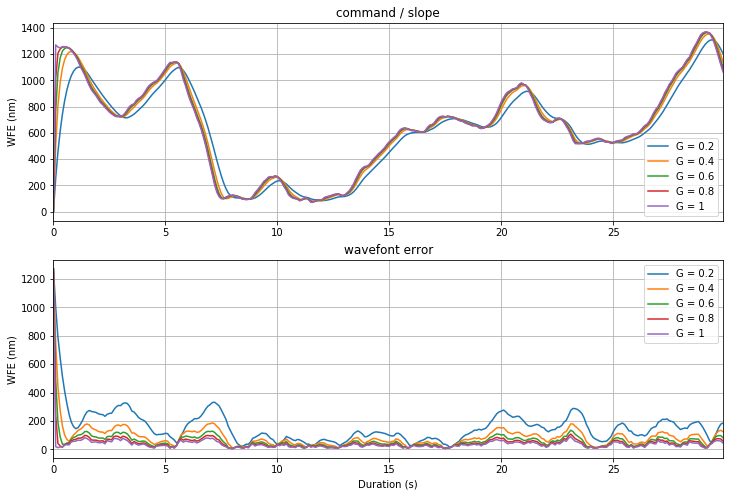

In [4]:
plot_wfe(range(0,3), 1)

## Zernikes 4-100 at 1 Hz

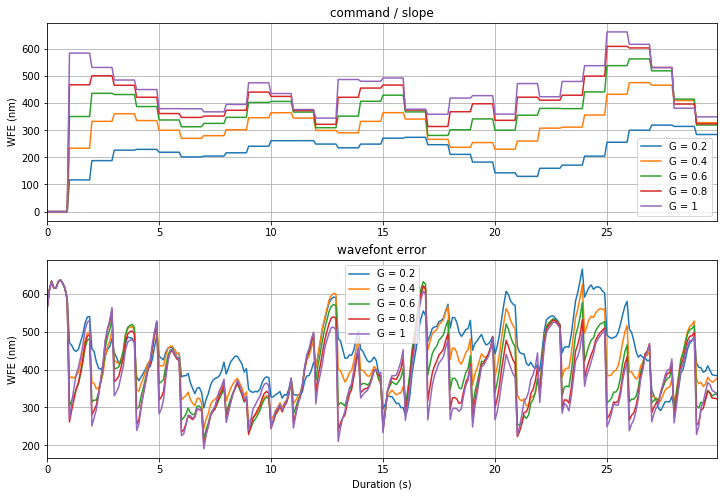

In [5]:
plot_wfe(range(3,100), 10)